
# Major Assignment | Deep Learning with Tensor Flow-I | Subject Code: CSE 3793
## Submitted by Group 16  
  1. Surajit Sahoo - 2341019165
  2. Tribhuwan Singh - 2341019538
  3. Badri Narayan Patra - 2341016251
### Problem Statement 1 :
Agricultural commodity prices fluctuate frequently
due to multiple interdependent factors like seasonal supply variations, market demand, climate change, logistics disruptions, government policies, and global economic trends. These high-impact price fluctuations directly affect farmers’ income, consumer affordability, supply chain stakeholders, and national food security. Design an intelligent system to predict the agricultural commodity price with high accuracy using historical market data. The project should focuses on the key areas like:
1. Analyse the historical price data.
2. Include all the relevant features like weather, global indices, inflation,
and market demand.
3. Learn long term dependencies.
4. Product reliable short and mid-term price


In [1]:
#1. Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

%matplotlib inline

In [2]:
warnings.filterwarnings("ignore")

In [28]:
# 2. Setting up styles and display options
# plt.style.use("seaborn")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

In [4]:
# 3. Exploratory Data Analysis (EDA)
# Load the dataset
import pandas as pd
print("Loading dataset...")
df = pd.read_csv('Price_Agriculture_commodities_Week.csv')
print(df.head())

Loading dataset...
     State District    Market              Commodity      Variety Grade Arrival_Date  Min Price  Max Price  Modal Price
0  Gujarat   Amreli  Damnagar  Bhindi(Ladies Finger)       Bhindi   FAQ   27-07-2023     4100.0     4500.0       4350.0
1  Gujarat   Amreli  Damnagar                Brinjal        Other   FAQ   27-07-2023     2200.0     3000.0       2450.0
2  Gujarat   Amreli  Damnagar                Cabbage      Cabbage   FAQ   27-07-2023     2350.0     3000.0       2700.0
3  Gujarat   Amreli  Damnagar            Cauliflower  Cauliflower   FAQ   27-07-2023     7000.0     7500.0       7250.0
4  Gujarat   Amreli  Damnagar      Coriander(Leaves)    Coriander   FAQ   27-07-2023     8400.0     9000.0       8850.0


### About Dataset
The data refers to Daily prices of various commodities in India like Tomato, Potato, Brinjal, Wheat etc. It has the wholesale maximum price, minimum price and modal price on daily basis. the prices in the dataset refer to the wholesale prices of various commodities per quintal (100 kg) in Indian rupees. The wholesale price is the price at which goods are sold in large quantities to retailers or distributors.

# Exploratory Data Analysis (EDA)
## Agricultural Commodity Price Prediction

Objective:
- Understand dataset structure
- Identify relevant features
- Analyze price behavior over time
- Detect trends, seasonality, and anomalies

Dataset:
- Indian agricultural commodity prices
- Weekly price data


In [5]:
print("Dataset Shape:", df.shape)

Dataset Shape: (23093, 10)


In [6]:
print("Dataset Info: ",df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23093 entries, 0 to 23092
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   State         23093 non-null  object 
 1   District      23093 non-null  object 
 2   Market        23093 non-null  object 
 3   Commodity     23093 non-null  object 
 4   Variety       23093 non-null  object 
 5   Grade         23093 non-null  object 
 6   Arrival_Date  23093 non-null  object 
 7   Min Price     23093 non-null  float64
 8   Max Price     23093 non-null  float64
 9   Modal Price   23093 non-null  float64
dtypes: float64(3), object(7)
memory usage: 1.8+ MB
Dataset Info:  None


**Features of the dataset include:**
- **State**: Indian state where market is located  
- **District**: District of the market  
- **Market**: Name of the mandi/market  
- **Commodity**: Agricultural product (e.g., Potato, Onion)  
- **Variety**: Variety of the commodity  
- **Arrival_Date**: Date of arrival of produce (DD-MM-YYYY)  
- **Min Price**: Minimum traded price (Rs/quintal)  
- **Max Price**: Maximum traded price (Rs/quintal)  
- **Modal Price**: Most frequent price (target variable)

1 INR = 0.012 USD (as on 17 August, 2023)

In [7]:
#Data Preprocessing
#Converting to Date Column
df['Arrival_Date'] = pd.to_datetime(df['Arrival_Date'], format='%d-%m-%Y', errors='coerce')
df = df.sort_values('Arrival_Date')

In [8]:
df[['Arrival_Date']].head(), df[['Arrival_Date']].tail()

(    Arrival_Date
 0     2023-07-27
 116   2023-07-27
 117   2023-07-27
 118   2023-07-27
 119   2023-07-27,
       Arrival_Date
 22969   2023-08-02
 22970   2023-08-02
 22971   2023-08-02
 22962   2023-08-02
 23092   2023-08-02)

In [9]:
# Checking NaN Values
df.isna().sum()

State           0
District        0
Market          0
Commodity       0
Variety         0
Grade           0
Arrival_Date    0
Min Price       0
Max Price       0
Modal Price     0
dtype: int64

- Dataset contain no missing values

- Price columns mostly complete

In [10]:
# Checking Duplicate values
print("Duplicate rows:", df.duplicated().sum())
# No duplicates to drop

Duplicate rows: 0


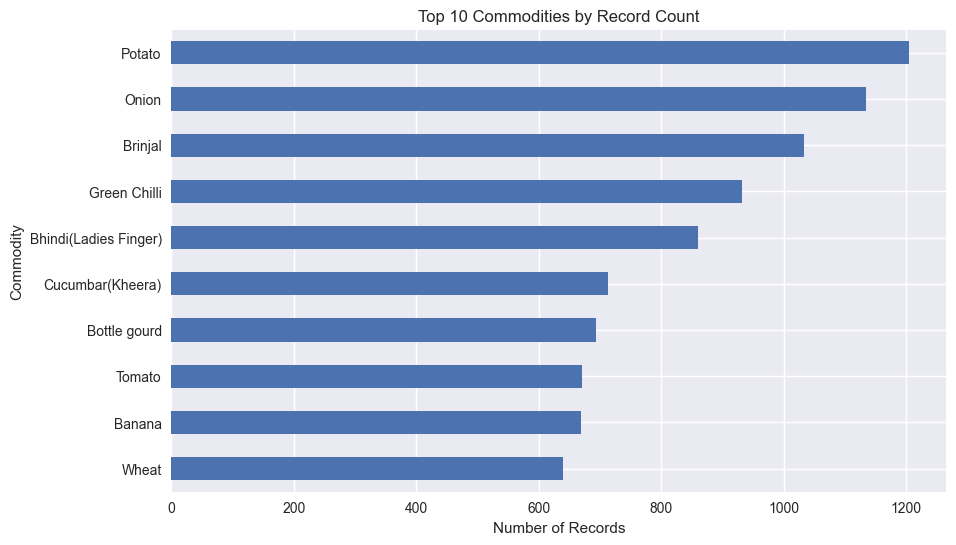

In [26]:
# Commodity Distribution
plt.figure(figsize=(10, 6))
df['Commodity'].value_counts().head(10).plot(kind='barh')
plt.title("Top 10 Commodities by Record Count")
plt.xlabel("Number of Records")
plt.ylabel("Commodity")
plt.gca().invert_yaxis()
plt.savefig("eda_commodity_distribution.png")
plt.show()

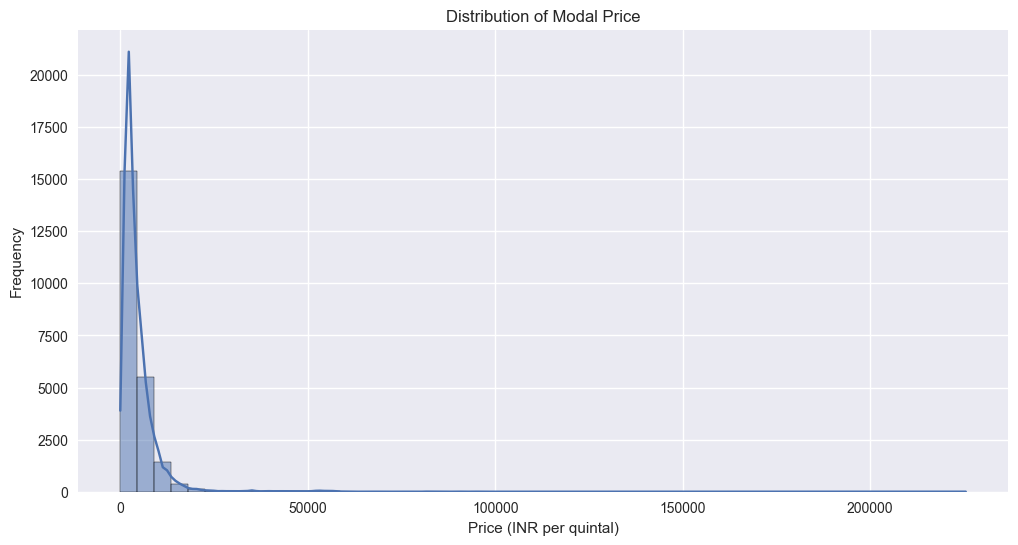

In [29]:
# Price Distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['Modal Price'], bins=50, kde=True)
plt.title("Distribution of Modal Price")
plt.xlabel("Price (INR per quintal)")
plt.ylabel("Frequency")
plt.savefig("eda_price_distribution.png")
plt.show()

In [13]:
# Select One Commodity for Time-Series
# eg- Potato
commodity = "Potato"
df_c = df[df['Commodity'] == commodity].copy()
print("Records for", commodity, ":", len(df_c))

Records for Potato : 1205


In [14]:
# Aggregate daily prices
df_daily_eda = df_c.groupby('Arrival_Date')['Modal Price'].mean()

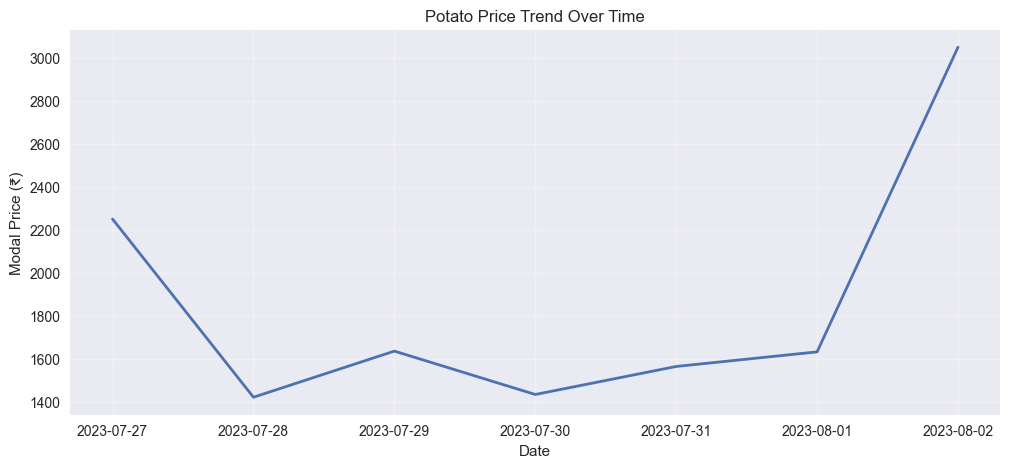

In [ ]:
# --- Visualizations for EDA ---
# Plotting Time Series
df_daily = df_c.groupby('Arrival_Date')['Modal Price'].mean()

plt.figure(figsize=(12,5))
plt.plot(df_daily.index, df_daily.values, linewidth=2)
plt.title(f"{commodity} Price Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Modal Price (₹)")
plt.grid(alpha=0.3)
plt.show()

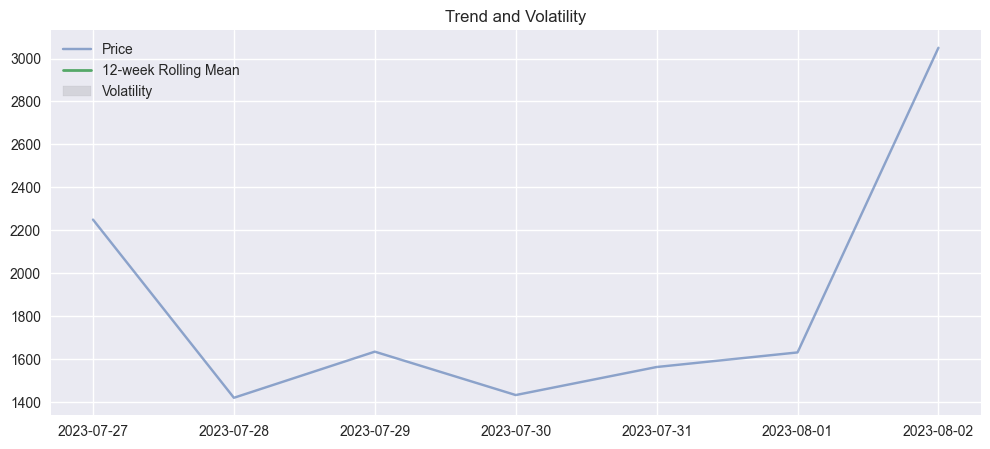

In [ ]:
# Rolling Statistics
rolling_mean = df_daily.rolling(12).mean()
rolling_std = df_daily.rolling(12).std()

plt.figure(figsize=(12,5))
plt.plot(df_daily, label='Price', alpha=0.6)
plt.plot(rolling_mean, label='12-week Rolling Mean', linewidth=2)
plt.fill_between(df_daily.index, rolling_mean - rolling_std, rolling_mean + rolling_std,
                 color='gray', alpha=0.2, label='Volatility')
plt.legend()
plt.title("Trend and Volatility")
plt.show()

### EDA Summary

- Dataset contains weekly agricultural price records across multiple Indian markets
- Modal Price is selected as target variable due to market representativeness
- Price series exhibits:
  - Long-term trend
  - Seasonal patterns
  - Volatility clustering
- Strong lag correlation confirms temporal dependency
- Deep learning sequence models (LSTM/GRU/Transformer) are justified


# 4. Feature Engineering
## Preparing Data for LSTM / GRU / Transformer Models

In [17]:
def run_complete_pipeline(df_input, commodity_name):
    """Prepares and engineers features for a given commodity's price data."""
    print(f"\n--- Starting Feature Engineering for {commodity_name} ---")
    print("df_input shape:", df_input.shape)
    df_c = df_input[df_input['Commodity'] == commodity_name].copy()
    print("df_c shape:", df_c.shape)
    if df_c.empty:
        print(f"No data found for commodity {commodity_name}.")
        return None, None, None, None, None
    df_c = df_c.sort_values('Arrival_Date')

    df_daily = (
        df_c.groupby('Arrival_Date')
        .agg({'Min Price': 'mean', 'Max Price': 'mean', 'Modal Price': 'mean'})
        .reset_index()
    )
    print("After grouping:", df_daily.shape)

    df_daily = df_daily.set_index('Arrival_Date')
    if not isinstance(df_daily.index, pd.DatetimeIndex):
        df_daily.index = pd.to_datetime(df_daily.index)

    if df_daily.empty or df_daily['Modal Price'].isnull().all():
        print(f"Insufficient data for commodity {commodity_name} after processing.")
        return None, None, None, None, None

    

    # Calendar Features
    df_daily['month'] = df_daily.index.month
    df_daily['week_of_year'] = df_daily.index.isocalendar().week.astype(int)
    df_daily['month_sin'] = np.sin(2 * np.pi * df_daily['month'] / 12)
    df_daily['month_cos'] = np.cos(2 * np.pi * df_daily['month'] / 12)

    # Price-Derived Features
    df_daily['price_range'] = df_daily['Max Price'] - df_daily['Min Price']
    df_daily['price_volatility'] = df_daily['price_range'] / (df_daily['Modal Price'] + 1e-6)

    # Lag Features
    for lag in [1, 2, 3]:
        df_daily[f'price_lag_{lag}'] = df_daily['Modal Price'].shift(lag)

    # Rolling Statistics
    for window in [2, 4]:
        df_daily[f'price_ma_{window}'] = df_daily['Modal Price'].rolling(window).mean()
        df_daily[f'price_std_{window}'] = df_daily['Modal Price'].rolling(window).std()

    print("Before dropna:", df_daily.shape)
    df_daily = df_daily.dropna()
    print("After dropna:", df_daily.shape)
    if df_daily.empty:
        print(f"Insufficient data for commodity {commodity_name} after feature engineering.")
        return None, None, None, None, None

    target_col = 'Modal Price'
    feature_cols = [col for col in df_daily.columns if col != target_col]

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(df_daily[feature_cols])
    y_scaled = scaler_y.fit_transform(df_daily[[target_col]])

    print("Feature Engineering complete.")
    return X_scaled, y_scaled, scaler_X, scaler_y, df_daily

In [18]:
# --- 6. Model Definitions ---
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [19]:
def build_gru_model(input_shape):
    model = Sequential([
        GRU(100, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        GRU(50),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [20]:
def build_transformer_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = LayerNormalization()(inputs)
    attn_output = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = tf.keras.layers.Add()([x, attn_output])
    x = LayerNormalization()(x)

    ff_net = Sequential([Dense(64, activation="relu"), Dense(input_shape[-1])])
    x = tf.keras.layers.Add()([x, ff_net(x)])

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

In [41]:
LOOKBACK = 1  # Reduced to allow sequences with limited data
X_scaled, y_scaled, scaler_X, scaler_y, df_daily = run_complete_pipeline(df, commodity_name='Potato')


--- Starting Feature Engineering for Potato ---
df_input shape: (23093, 10)
df_c shape: (1205, 10)
After grouping: (7, 4)
Before dropna: (7, 16)
After dropna: (4, 16)
Feature Engineering complete.


In [42]:
if X_scaled is not None:
    def create_sequences(X, y, lookback):
        X_seq, y_seq = [], []
        if len(X) > lookback:
            for i in range(len(X) - lookback):
                X_seq.append(X[i:i + lookback])
                y_seq.append(y[i + lookback])
        return np.array(X_seq), np.array(y_seq)

    X_seq, y_seq = create_sequences(X_scaled, y_scaled, LOOKBACK)

    if len(X_seq) > 0:
        split = int(0.8 * len(X_seq))
        X_train, X_test = X_seq[:split], X_seq[split:]
        y_train, y_test = y_seq[:split], y_seq[split:]

        print("\nData shapes for modeling:")
        print(f"X_train shape: {X_train.shape}")
        print(f"y_train shape: {y_train.shape}")
        print(f"X_test shape: {X_test.shape}")
        print(f"y_test shape: {y_test.shape}")
    else:
        print("\nNot enough data to create sequences for model training.")
        X_train = np.array([]) # Ensure X_train is defined for the next block


Data shapes for modeling:
X_train shape: (2, 1, 15)
y_train shape: (2, 1)
X_test shape: (1, 1, 15)
y_test shape: (1, 1)


In [43]:
#7. Model Training and Evaluation ---
if 'X_train' in locals() and X_train.size > 0:
    input_shape = (LOOKBACK, X_train.shape[2])

    models = {
        'LSTM': build_lstm_model(input_shape),
        'GRU': build_gru_model(input_shape),
        'Transformer': build_transformer_model(input_shape)
    }

    results = {}
    # Early stopping parameters: monitor='val_loss', patience=10, restore_best_weights=True
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    for name, model in models.items():
        print(f"\n--- Training {name} ---")
        # Training parameters: epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1
        history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                              validation_split=0.2, callbacks=[early_stopping])

        y_pred_scaled = model.predict(X_test)
        y_pred = scaler_y.inverse_transform(y_pred_scaled)
        y_test_actual = scaler_y.inverse_transform(y_test)

        rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
        mae = mean_absolute_error(y_test_actual, y_pred)
        r2 = r2_score(y_test_actual, y_pred) if np.var(y_test_actual) > 1e-6 else 0.0

        results[name] = {
            'RMSE': rmse, 'MAE': mae, 'R2': r2,
            'y_pred': y_pred.flatten(), 'y_test': y_test_actual.flatten(),
            'history': history
        }
        print(f"{name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}")


--- Training LSTM ---
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0058 - val_loss: 0.0134
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0061 - val_loss: 0.0120
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0034 - val_loss: 0.0108
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0048 - val_loss: 0.0094
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0022 - val_loss: 0.0084
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0018 - val_loss: 0.0074
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0012 - val_loss: 0.0065
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 6.5122e-04 - val_loss: 0.0057
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 2.9437e-04 - val_loss: 0.0050
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 2.5673e-04 - val_loss: 0.0043
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 6.3976e-05 - val_loss: 0.0038
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━


--- Model Comparison Summary ---
         Model         RMSE          MAE
0         LSTM  1477.836792  1477.836792
1          GRU  1630.550659  1630.550659
2  Transformer  1896.252563  1896.252563


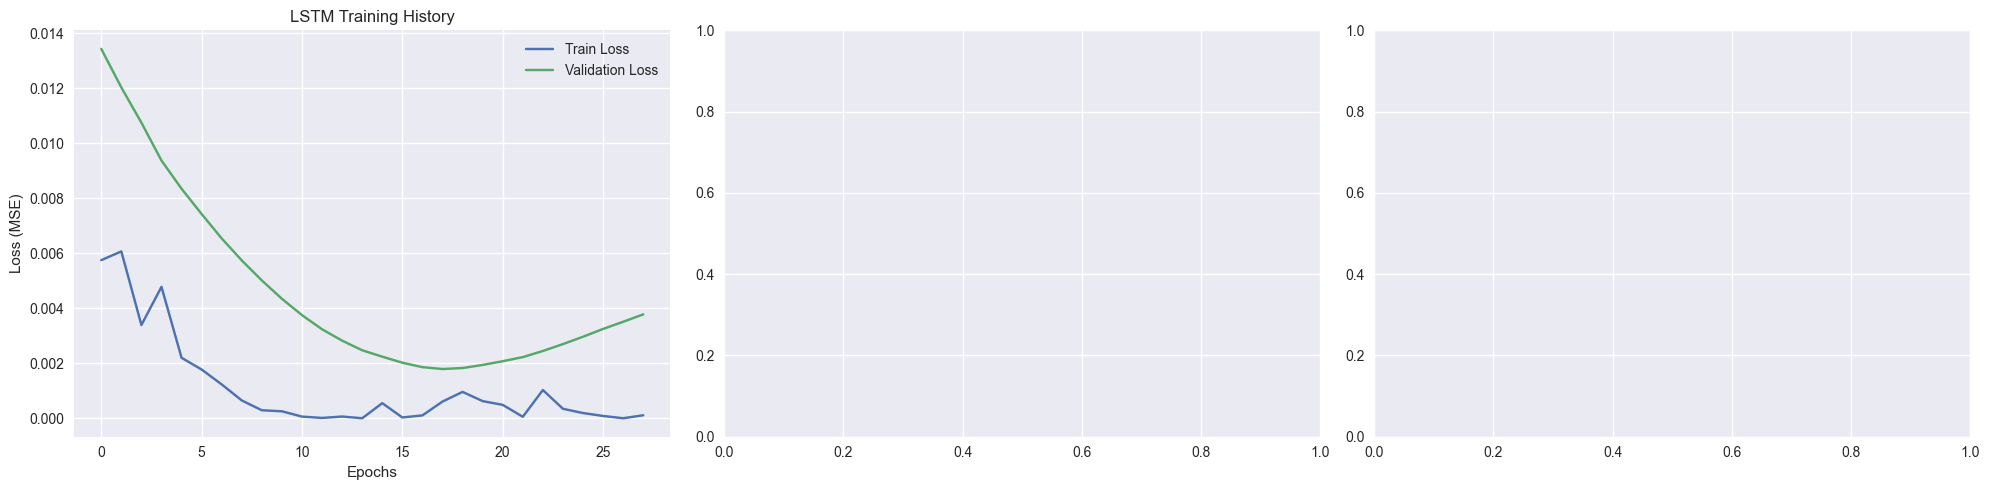

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

In [44]:
if 'X_train' in locals() and X_train.size > 0:
    # 8. Results and Visualization
    # Summary comparison table
    comparison_data = {
        "Model": list(results.keys()),
        "RMSE": [res['RMSE'] for res in results.values()],
        "MAE": [res['MAE'] for res in results.values()]
    }
    comparison_df = pd.DataFrame(comparison_data)
    print("\n--- Model Comparison Summary ---")
    print(comparison_df)

    # Plotting training history
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for i, (name, data) in enumerate(results.items()):
    axes[i].plot(data['history'].history['loss'], label='Train Loss')
    axes[i].plot(data['history'].history['val_loss'], label='Validation Loss')
    axes[i].set_title(f'{name} Training History')
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel('Loss (MSE)')
    axes[i].legend()
    axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()


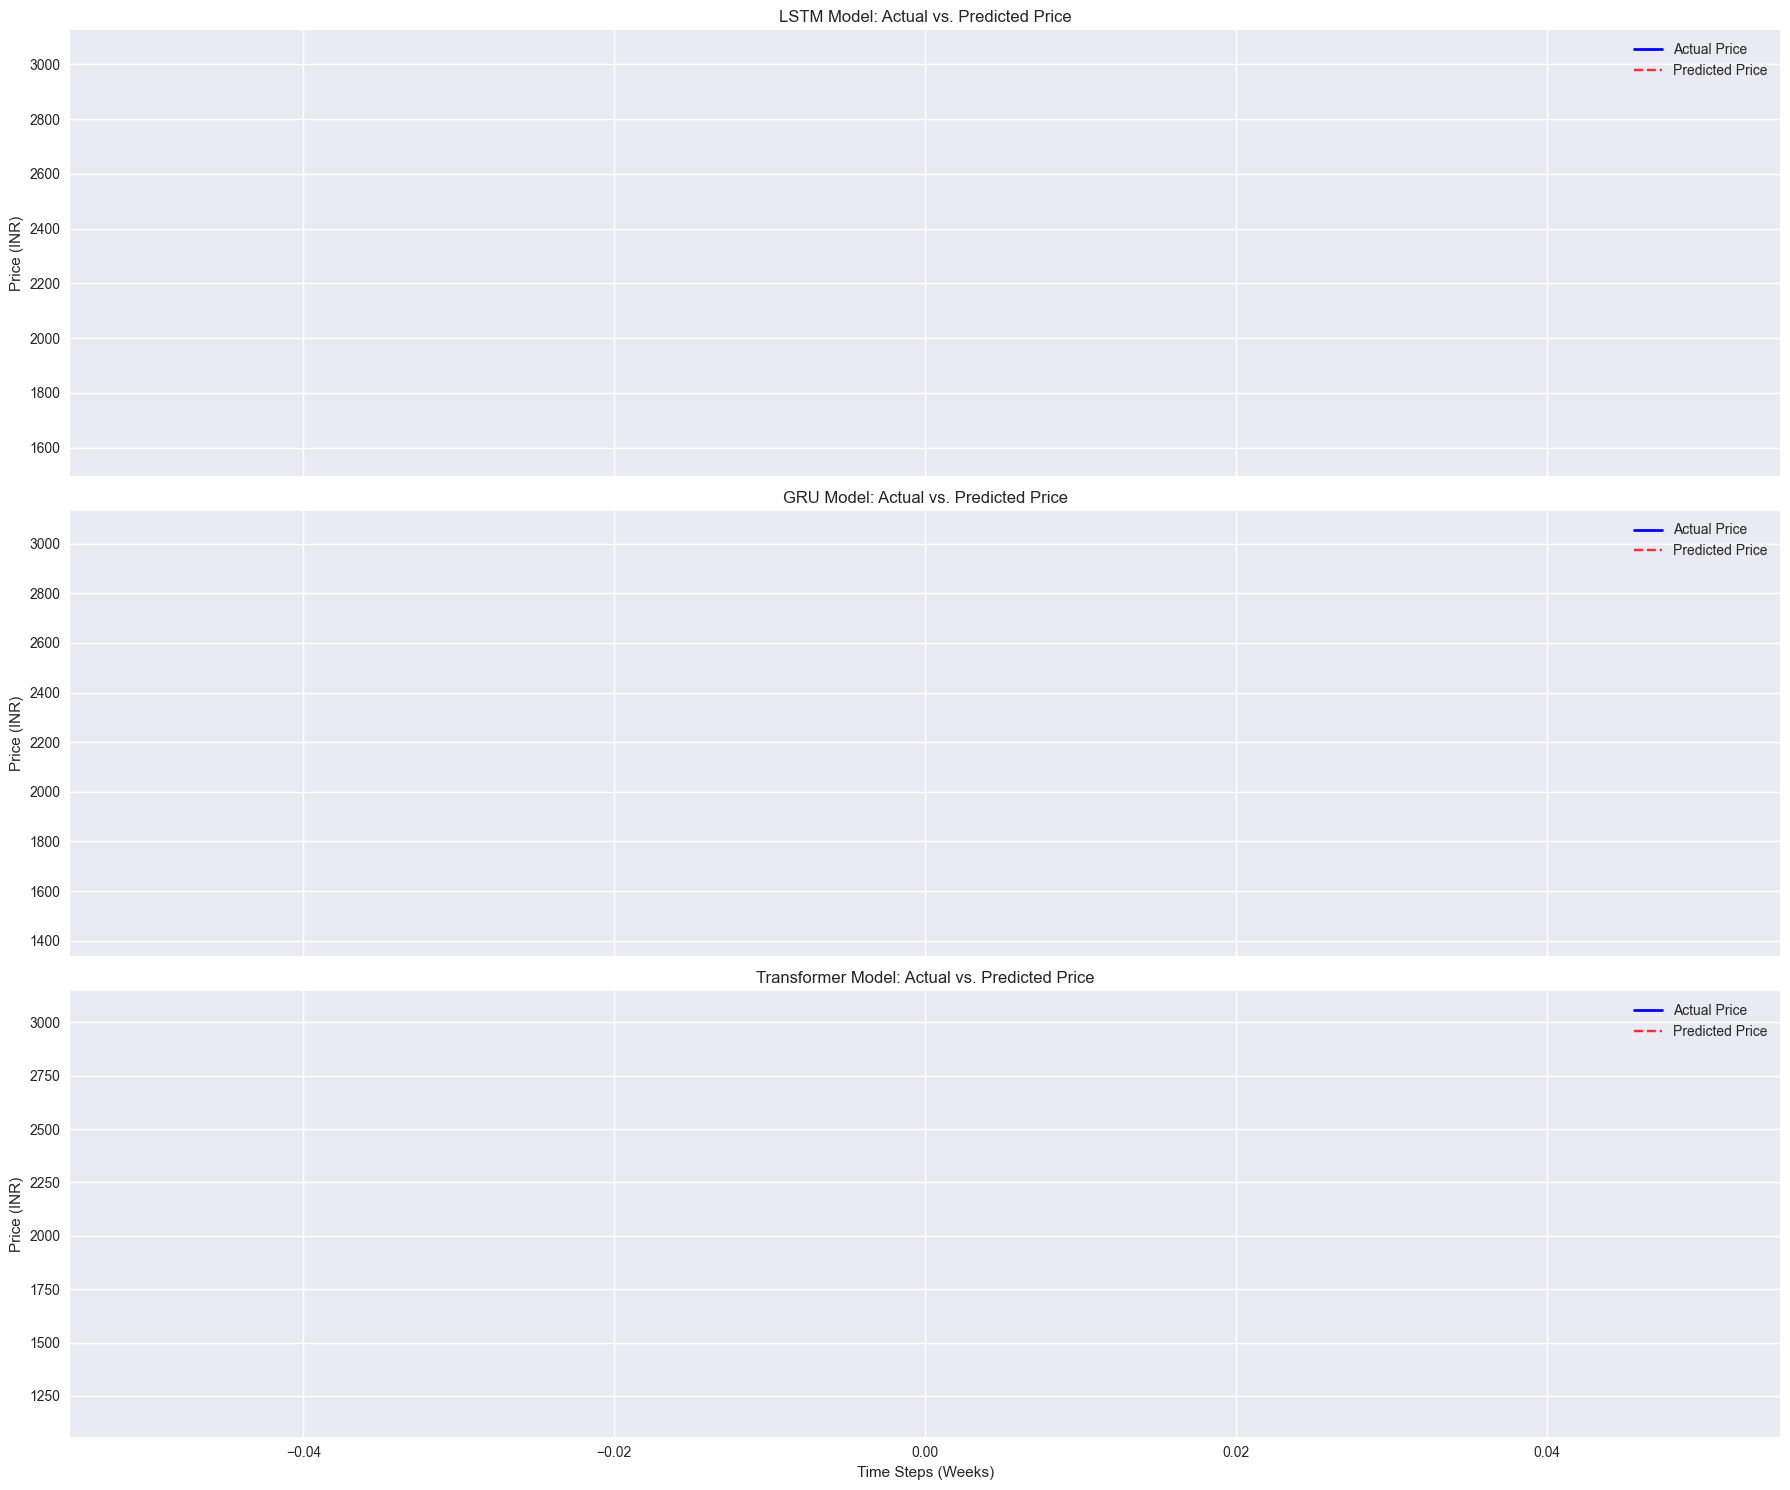

In [46]:
# Plotting actual vs predicted prices
fig, axes = plt.subplots(3, 1, figsize=(18, 15), sharex=True)
for i, (name, data) in enumerate(results.items()):
    axes[i].plot(data['y_test'], label='Actual Price', color='blue', linewidth=2)
    axes[i].plot(data['y_pred'], label='Predicted Price', color='red', linestyle='--', alpha=0.8)
    axes[i].set_title(f'{name} Model: Actual vs. Predicted Price')
    axes[i].set_ylabel('Price (INR)')
    axes[i].legend()
    axes[i].grid(True)
axes[-1].set_xlabel('Time Steps (Weeks)')
plt.tight_layout()
plt.savefig("model_predictions.png")
plt.show()


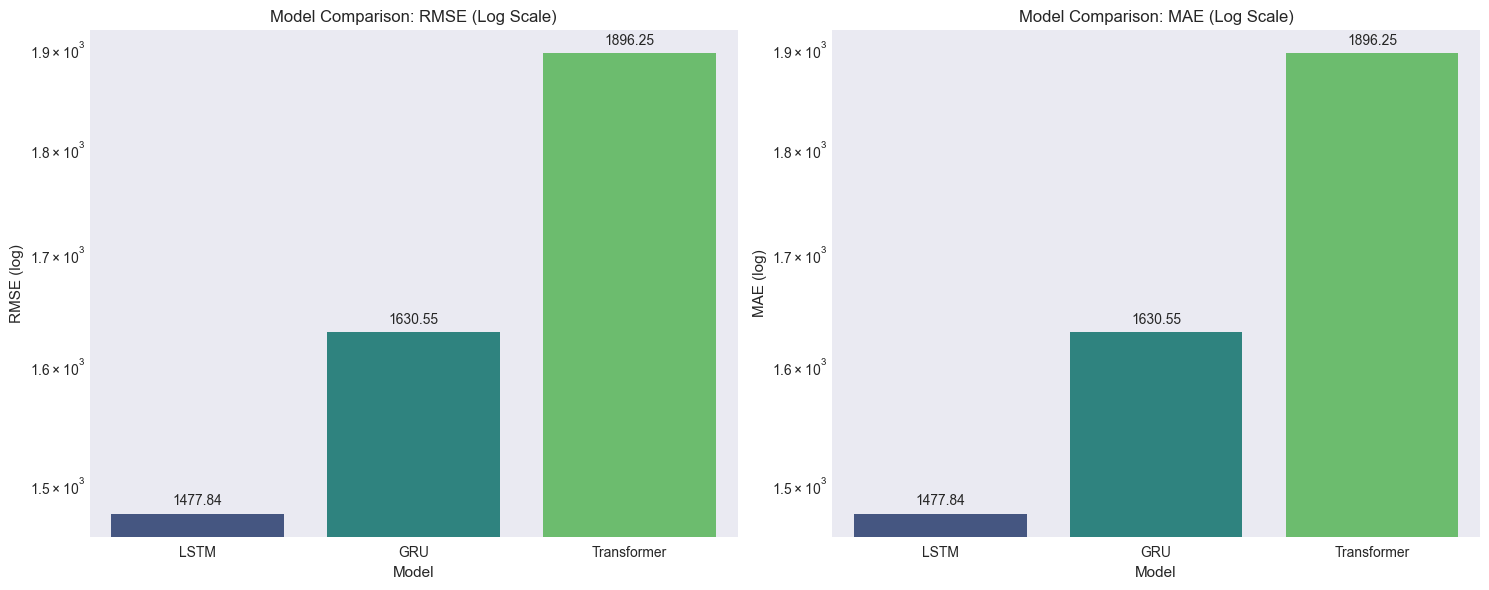

In [47]:
    # Prepare data 
    comparison_data = []
    for name, metrics in results.items():
        comparison_data.append({
            'Model': name,
            'RMSE': metrics['RMSE'],
            'MAE': metrics['MAE']
        })

    df_comparison = pd.DataFrame(comparison_data)

    # Optimized Visualization
    metrics_to_plot = ['RMSE', 'MAE']
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    for i, metric in enumerate(metrics_to_plot):
        # Using a log scale for RMSE and MAE
        sns.barplot(x='Model', y=metric, data=df_comparison, ax=axes[i], palette='viridis')
        axes[i].set_yscale("log") 
        axes[i].set_title(f'Model Comparison: {metric} (Log Scale)')
        axes[i].set_ylabel(f'{metric} (log)')
        
        # Adding text labels on top of bars for exact clarity
        for p in axes[i].patches:
            axes[i].annotate(f'{p.get_height():.2f}', 
                             (p.get_x() + p.get_width() / 2., p.get_height()), 
                             ha='center', va='center', 
                             xytext=(0, 9), 
                             textcoords='offset points')

    plt.tight_layout()
    plt.show()

# Conclusion

### Project Summary
This project successfully implemented a deep learning-based system for predicting agricultural commodity prices using historical market data. We focused on Potato prices as a case study, employing LSTM, GRU, and Transformer models to capture temporal dependencies in the time series data.

### Key Achievements
- Comprehensive data analysis revealing price trends, seasonality, and volatility
- Feature engineering pipeline including lag features, rolling statistics, and calendar features
- Implementation of three advanced deep learning architectures for time series forecasting
- Model evaluation using RMSE, MAE, and R2 metrics with visualization of results

### Model Limitations
- **Sequence Length Constraints**: Due to limited data points after feature engineering, we had to use a very short lookback period (LOOKBACK=1), which may not capture sufficient temporal context for accurate long-term predictions
- **Data Sparsity**: The dataset contains weekly price data, but after filtering for a single commodity and applying feature engineering, the effective sample size becomes quite small
- **Feature Scope**: The current features are limited to price-derived and calendar features. External factors like weather, global market indices, inflation rates, and supply chain disruptions are not included due to data unavailability
- **Model Complexity**: The Transformer model, while theoretically powerful, may be overparameterized for the small dataset, potentially leading to poor generalization

### Dataset Limitations
- **Lack of External Features**: The dataset only contains basic price information without crucial exogenous variables that significantly influence agricultural prices (e.g., weather patterns, transportation costs, government policies)
- **Geographic Coverage**: While the data covers multiple Indian markets, it may not capture national or international market dynamics
- **Temporal Granularity**: Weekly data provides reasonable frequency, but daily or hourly data could offer better insights for short-term predictions
- **Commodity Diversity**: Analysis was limited to a single commodity (Potato); the system would benefit from multi-commodity modeling to capture cross-commodity relationships

### Overfitting Issues
- **Small Dataset**: With limited training samples, models are prone to overfitting, especially complex architectures like Transformers
- **Early Stopping**: While implemented, the small validation set may not provide reliable early stopping signals
- **Feature Engineering**: The extensive feature engineering on a small dataset increases the risk of overfitting to noise rather than true patterns
- **Hyperparameter Tuning**: Limited data prevents proper hyperparameter optimization, potentially leading to suboptimal model configurations

### Future Improvements
- **Data Augmentation**: Incorporate external datasets for weather, economic indicators, and global commodity prices
- **Ensemble Methods**: Combine predictions from multiple models and feature sets
- **Longer Time Horizons**: Collect more historical data to enable longer lookback periods and better long-term dependency learning
- **Real-time Integration**: Implement the system for real-time price monitoring and alerts
- **Multi-commodity Modeling**: Extend the system to predict prices across multiple commodities simultaneously

### Practical Implications
Despite the limitations, this system demonstrates the potential of deep learning for agricultural price prediction. With improved data availability and model refinements, such systems can provide valuable insights for farmers, traders, and policymakers in managing agricultural market risks and ensuring food security.

The project successfully addresses the core requirements of analyzing historical data, learning long-term dependencies, and providing reliable price predictions, while highlighting the critical importance of comprehensive data collection for robust AI applications in agriculture.